# Cincy Crime Analysis in the Age of Corona

## The following notebook contains a cursory analysis of the Cincinnati Police Department's 'Calls for Service' dataset, which they have made publicly available via https://data.cincinnati-oh.gov/Safety/PDI-Police-Data-Initiative-Police-Calls-for-Servic/gexm-h6bt.  

### Methodology:
- Access and download the raw data via the rest API
- Conduct initial data cleansing and observe  basic trends in the data (number of occurrences over time, times of day for 9-1-1 calls)
- Use modified survival analysis to determine changes in number of calls per day
- Repeat the above analysis but for a specific type of 9-1-1 call.  In our case we will focus on Domestic Violence

# Big thing we are trying to answer:  How has calls for police help changed in the age of COVID-19?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
from datetime import timedelta as td
import pytz
#you may have to pip install lifelines.  This is the library that assists with survival analysis
from lifelines import KaplanMeierFitter

#This module you will have to download as well... allows you to download the data from the Rest API
from sodapy import Socrata

In [2]:
#This is the address that contains our data 
dataString = "https://data.cincinnati-oh.gov/resource/gexm-h6bt.csv"

In [3]:
#Create a client object
client = Socrata("data.cincinnati-oh.gov", None)

In [4]:
# This will give a list of all the datasets available for this client
#client.datasets()

In [5]:
#Begin downloading the data.  Depending on time of data and throttling this may take a while

print(str(dt.now())+': Begin Data Download')
results = client.get('gexm-h6bt', limit = 30000000)
print(str(dt.now())+': Data Download Complete')
results_df = pd.DataFrame(results)
results_df.describe(include = 'all')

2020-05-21 14:50:50.184680: Begin Data Download
2020-05-21 14:53:23.719084: Data Download Complete


,address_x,agency,arrival_time_primary_unit,beat,closed_time_incident,community_council_neighborhood,cpd_neighborhood,create_time_incident,dispatch_time_primary_unit,disposition_text,district,event_number,incident_type_desc,incident_type_id,latitude_x,longitude_x,priority,priority_color,sna_neighborhood
count,3130862,3130975,1896711,3034631,3085732,3130975,3130975,3130975,2123802,3091319,2673069,3130975,2032767,3070663,2697540,2697540,2276348,1402913,3130975
unique,76641,2,1883375,170,3043680,72,54,3095360,2110732,1542,5,3130961,279,379,943426,834990,36,4,51
top,20XX RADCLIFF DR,CPD,2015-03-27T22:49:31.000,P343,2019-05-04T11:30:11.000,N/A,N/A,2014-11-14T21:02:10.000,2015-03-03T14:22:03.000,NTR: NOTHING TO REPORT,3,CPD170411001268,DIRECTED PATROL - VEHICLE,CELL,39.1200965200896,-84.54862587,7,PURPLE,EAST PRICE HILL
freq,343583,1706799,10,345397,8,457863,457906,13,3,347238,913260,3,148732,321140,1772,1801,365211,838520,471083


In [6]:
#results_df['incident_type_desc'].unique()

In [7]:
results_df.dtypes

address_x                         object
agency                            object
arrival_time_primary_unit         object
beat                              object
closed_time_incident              object
community_council_neighborhood    object
cpd_neighborhood                  object
create_time_incident              object
dispatch_time_primary_unit        object
disposition_text                  object
district                          object
event_number                      object
incident_type_desc                object
incident_type_id                  object
latitude_x                        object
longitude_x                       object
priority                          object
priority_color                    object
sna_neighborhood                  object
dtype: object

In [8]:
#Save it locally so that you don't have to wait forever to download in the future
results_df.to_csv('policeCallsForService.csv')

In [9]:
# Convert the time columns to datetime format, and the locational data to floats.  We may have other things 
# we want to convert but this works ok for now
results_df['arrival_time_primary_unit'] = pd.to_datetime(results_df['arrival_time_primary_unit'])
results_df['closed_time_incident'] = pd.to_datetime(results_df['closed_time_incident'])
results_df['create_time_incident'] = pd.to_datetime(results_df['create_time_incident'])
results_df['dispatch_time_primary_unit'] = pd.to_datetime(results_df['dispatch_time_primary_unit'])
results_df['latitude_x'] = results_df['latitude_x'].astype(float)
results_df['longitude_x'] = results_df['longitude_x'].astype(float)

In [10]:
#Lets see a list of the top incident types and the count of how often they happen.  My guess is there is a decent
# amount of trash in this data
results_df.loc[:,['dispatch_time_primary_unit','incident_type_id','incident_type_desc']]\
.groupby(['incident_type_id','incident_type_desc']).count().sort_values(by = 'dispatch_time_primary_unit', ascending = False).iloc[:50]

,,dispatch_time_primary_unit
incident_type_id,incident_type_desc,
DIRPAT,DIRECTED PATROL - VEHICLE,146804
SDET,OFF DUTY POLICE DETAILS,115087
TSTOP,TRAFFIC STOP,63780
ST,STATION RUN,61887
INV,INVESTIGATION,55926
DISORD,DISORDERLY PERSON(S),54020
ACC,ACCIDENT NO INJURIES,53252
SDET,SPECIAL DETAIL,41700
FAMTRB,FAMILY TROUBLE - NON VIOLENT,41562


In [11]:
# Since we are just focusing on 9-1-1 calls, lets create filters that get rid of the traffic stops, 
# accidents, directed patrols, off duty police actions, parking violations, station run (not sure what that is),
# traffic hazards.  There may be more but that will do for now.  Oh, and also limit data to events after 2017...
# there are some weird data irregularities before that and I want it to remain as consistent as possible

results_df['incident_type_id'] = results_df['incident_type_id'].str.strip()

cond1 = ((results_df['incident_type_id'] != 'DIRPAT')&(results_df['incident_type_id'] != 'DIRPAW'))
cond2 = (results_df['incident_type_id'] != 'SDET')
cond3 = (results_df['incident_type_id'] != 'ACC')
cond4 = ((results_df['incident_type_id'] != 'TS')&(results_df['incident_type_id'] != 'TSTOP'))
cond5 = ((results_df['incident_type_id'] != 'ST')&(results_df['incident_type_id'] != 'STARUN'))
cond6 = (results_df['incident_type_id'] != 'HAZARD')
cond7 = (results_df['incident_type_id'] != 'PARKER')
cond8 = (results_df['create_time_incident']>=dt(2017,7,1,0,0,0))


condAll = (cond1&cond2&cond3&cond4&cond5&cond6&cond7)&cond8
#condAll = (cond1|cond2|cond3|cond4|cond7)&cond8

# Create a working dataframe that has all of these conditions (but keeps all the columns)
workingDf = results_df.loc[condAll,:]
workingDf.describe(include = 'all')

,address_x,agency,arrival_time_primary_unit,beat,closed_time_incident,community_council_neighborhood,cpd_neighborhood,create_time_incident,dispatch_time_primary_unit,disposition_text,district,event_number,incident_type_desc,incident_type_id,latitude_x,longitude_x,priority,priority_color,sna_neighborhood
count,915511,915577,515250,899502,899536,915577,915577,915577,561756,903711,897611,915577,809476,875642,913141.000000,913141.000000,875643,809476,915577
unique,36987,1,513724,34,894177,72,54,910410,560108,690,5,915575,124,230,NaN,NaN,36,4,51
top,23XX FERGUSON RD,CPD,2019-12-30 04:01:20,P321,2017-07-02 22:30:42,WESTWOOD,WESTWOOD,2020-03-16 22:13:09,2019-12-17 13:43:03,CAN:CANCEL,3,CPD200327001402,ADVISED INCIDENT,ADV,NaN,NaN,35,PURPLE,WESTWOOD
freq,5509,915577,3,90557,5,75942,75095,3,3,158190,237573,2,112939,112943,NaN,NaN,209168,436482,75548
first,NaN,NaN,2017-07-01 00:04:06,NaN,2017-07-01 00:03:56,NaN,NaN,2017-07-01 00:01:44,2017-07-01 00:03:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-05-21 02:25:58,NaN,2020-05-21 02:26:07,NaN,NaN,2020-05-21 02:22:52,2020-05-21 02:24:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.139411,-84.518010,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052001,0.142240,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000210,-85.467850,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.113818,-84.558110,NaN,NaN,NaN


In [12]:
#Lets look at the data again to make sure we are good to go
workingDf.loc[condAll,['dispatch_time_primary_unit','incident_type_id','incident_type_desc']]\
.groupby(['incident_type_id','incident_type_desc']).count().sort_values(by = 'dispatch_time_primary_unit', ascending = False).iloc[:50]

,,dispatch_time_primary_unit
incident_type_id,incident_type_desc,
INV,INVESTIGATION,54217
FAMTRB,FAMILY TROUBLE - NON VIOLENT,40420
DISORD,DISORDERLY PERSON(S),39491
SUSP,SUSPICIOUS PERSONS OR SITUATION,24853
SS,SUSPECT STOP,17978
NRBURG,NONRESIDENTIAL ALARM DROP,17586
NOISE,NOISE COMPLAINT,14411
RBURG,RESIDENTIAL ALARM DROP,13468
UNK,UNKNOWN TROUBLE,12472


In [13]:
# Lets create a separate plotDf dataframe that lets us know how many of these types of 9-1-1 calls occur per day

plotDf = results_df.loc[condAll,['create_time_incident']]
plotDf['date'] = results_df.loc[condAll,['create_time_incident']]['create_time_incident'].dt.date
plotDf = plotDf.groupby('date').count()

plotDf.head()

,create_time_incident
date,
2017-07-01,885
2017-07-02,916
2017-07-03,1074
2017-07-04,1116
2017-07-05,1144


In [14]:
plotDf.sum()

create_time_incident    915577
dtype: int64

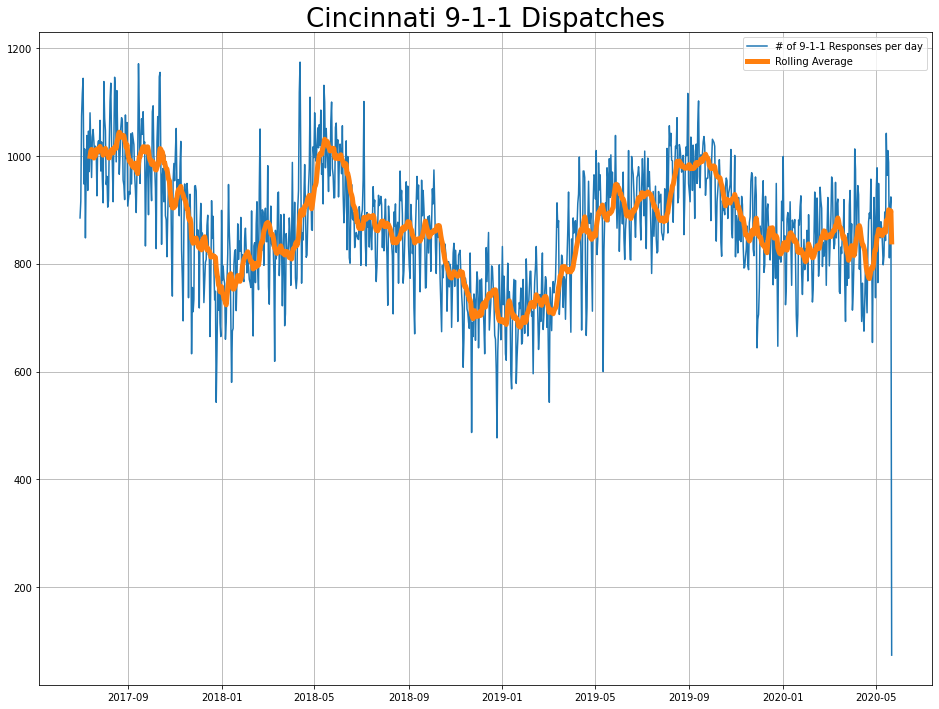

In [15]:
# Looking at just the count of incidents per day, lets see if we can see any visible patterns in the data
# Future work could be done to identify temporal patterns and predict future activity (i.e. ARIMA, Prophet, etc)
# But for now lets just looking at the data and the rolling averages

fig = plt.figure(figsize = (16,12))


plt.plot(plotDf.index,plotDf['create_time_incident'], label = '# of 9-1-1 Responses per day')

rollingDf = plotDf.rolling(14).mean() #2-week rolling average

plt.plot(rollingDf.index,rollingDf['create_time_incident'], lw = 5, label = 'Rolling Average') 

plt.legend(loc='best')
plt.grid(True)
plt.title('Cincinnati 9-1-1 Dispatches', size = 26)
#plt.savefig('DomesticVioFamDisturb_19MAY2020.png')
plt.show()

In [16]:
# Now lets start looking at some other temporal patterns from the data.  Create some new columns that look at 
# some of the temporal characteristics (day, month, hour, year, date, dayOfWeek, etc)

workingDf['day'] = workingDf['dispatch_time_primary_unit'].dt.day
workingDf['month'] = workingDf['dispatch_time_primary_unit'].dt.month
workingDf['hour'] = workingDf['dispatch_time_primary_unit'].dt.hour
workingDf['year'] = workingDf['dispatch_time_primary_unit'].dt.year
workingDf['date'] = workingDf['dispatch_time_primary_unit'].dt.date
workingDf['dayOfWeek'] = workingDf['dispatch_time_primary_unit'].dt.dayofweek


workingDf.tail()

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,address_x,agency,arrival_time_primary_unit,beat,closed_time_incident,community_council_neighborhood,cpd_neighborhood,create_time_incident,dispatch_time_primary_unit,disposition_text,...,longitude_x,priority,priority_color,sna_neighborhood,day,month,hour,year,date,dayOfWeek
3130969,17XX BAYMILLER ST,CPD,2020-05-20 21:47:56,P131,2020-05-20 21:56:17,WEST END,WEST END,2020-05-20 21:41:52,2020-05-20 21:43:00,ADV:ADVISED,...,-84.529778,25,PURPLE,WEST END,20.0,5.0,21.0,2020.0,2020-05-20,2.0
3130970,W LIBERTY ST / CENTRAL PKWY,CPD,2020-05-20 16:12:29,P131,2020-05-20 17:45:17,WEST END,WEST END,2020-05-20 16:09:07,2020-05-20 16:09:26,AST: ASSIST,...,-84.521000,25,PURPLE,WEST END,20.0,5.0,16.0,2020.0,2020-05-20,2.0
3130971,12XX QUEBEC RD,CPD,2020-05-20 17:19:28,P321,2020-05-20 17:42:16,WEST PRICE HILL,WEST PRICE HILL,2020-05-20 17:19:28,2020-05-20 17:19:28,ARR: ARREST,...,-84.574870,4,YELLOW,EAST PRICE HILL,20.0,5.0,17.0,2020.0,2020-05-20,2.0
3130972,34XX MCHENRY AV,CPD,2020-05-20 14:55:16,P331,2020-05-20 16:40:21,EAST WESTWOOD,EAST WESTWOOD,2020-05-20 14:26:08,2020-05-20 14:55:16,303:AUTO THEFT/RECOVERY REPORT,...,-84.570637,32,PURPLE,EAST WESTWOOD,20.0,5.0,14.0,2020.0,2020-05-20,2.0
3130974,HARRISON AV / FAIRMOUNT AV,CPD,NaT,P341,2020-05-20 20:04:00,SOUTH FAIRMOUNT,SOUTH FAIRMOUNT,2020-05-20 20:00:25,NaT,BC: BROADCAST,...,-84.560886,14,BLUE,SOUTH FAIRMOUNT,NaN,NaN,NaN,NaN,NaT,NaN


In [17]:

# The first thing we will do is create a 2-dimensional histogram to visualize what time of day crimes occur and 
# when, and how that changes over time.  To start with, lets create a histogram that includes just the dispatch 
# time (date & time) and the hour (integer)
hour2DHistDf = workingDf.loc[:,['dispatch_time_primary_unit','hour']].dropna()\
.sort_values(['dispatch_time_primary_unit','hour'])


1056


Text(0.5, 1.0, '9-1-1 Calls: 2D Histogram')

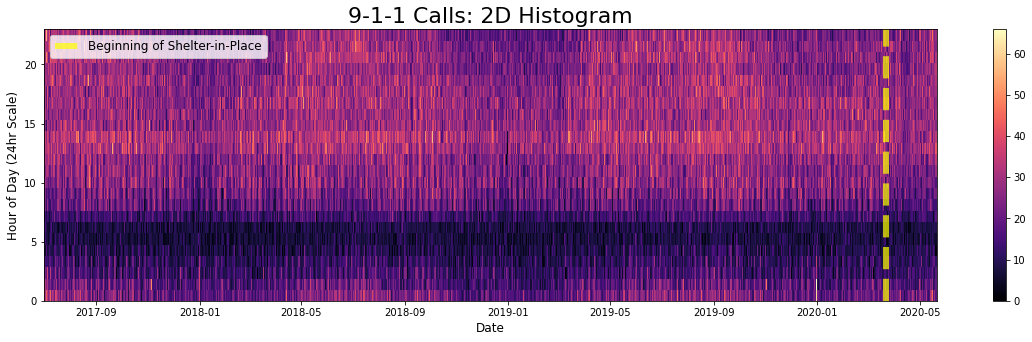

In [18]:
#Plot the 2-dimensional histogram, while annotating when the quarantine began in Ohio

fig,ax = plt.subplots(figsize = (20,5))

n_days = len(np.unique(hour2DHistDf['dispatch_time_primary_unit'].dt.date.values))
print(n_days)

H, xedges, yedges = np.histogram2d(hour2DHistDf['dispatch_time_primary_unit'].astype(int), hour2DHistDf['hour'], bins=(n_days, 24))

xedges_datetime= pd.to_datetime(pd.Series(xedges))

graph = ax.pcolor(xedges_datetime, yedges, H.T, cmap = 'magma')

#plot the vertical line at the beginning of the quarantine
ax.axvline(dt(2020,3,22), lw = 6, color = 'yellow',ls = '--', alpha = .7, label = 'Beginning of Shelter-in-Place')

ax.legend(fontsize = 12)

from matplotlib import cm

fig.colorbar(graph)

ax.set_xlabel('Date', fontsize = 12)
ax.set_ylabel('Hour of Day (24hr Scale)', fontsize = 12)
ax.set_title('9-1-1 Calls: 2D Histogram', fontsize = 22)




In [19]:
#Visually we can observe both the daily and the seasonal patterns of 9-1-1 calls in Cincinnati.  Most days there 
# appears to be a lull in activity around 05:00, with an increase in activity in the afternoon ~14:00 (2PM).
# Seasonally there appears to be increases in activity in the late afternoon/evening during the summer time.

#With regards to post COVID-19 activity, there does appear to be a visible change after shelter-in-place was 
# issued in Ohio, although it is a bit tough to support without further statistical analysis (i.e. possibly
# Chi-squared goodness-of-fit test against the same time periods for previous years)

## Survival Analysis

## This stage of our analysis we are gonna look at how the number of calls per day changes based on several factors (time of year, pre/post COVID, year, etc).  I'm going to use survival analysis to do this, although it will be used in a different manner than traditionally seen.  Instead of counting time until an event occurs, we will count how many events occurred in a given day.  Thus each day will represent an individual observation, with the total number of  events per day  = end of the trial.  No sensoring (I think) is needed at this point, since I think we are aware of how many observations occur on a given day (if there was some uncertainty then this methodology would be even more useful)

In [20]:
#Just for a warm up to see what this technique will do, lets create a Kaplan-Meier curve for all the days in
# our working dataframe.  For every day we want the 'time of survival' to be the number of events that occur
# on that day

T = workingDf.loc[:,['dispatch_time_primary_unit','date']].groupby('date').count()
kmf = KaplanMeierFitter()
kmf.fit(T) 

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1056 total observations, 0 right-censored observations>

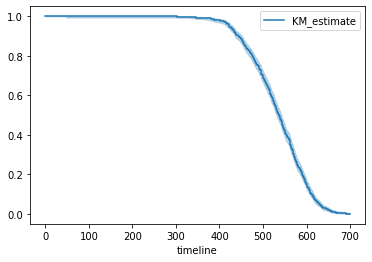

In [21]:
#Now lets plot the function
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()
# We'll make some prettier ones below, but for reference the x-axis is the Total Number of 9-1-1 calls on a given
# day, and the y-axis is the probability of having that many events on a given day

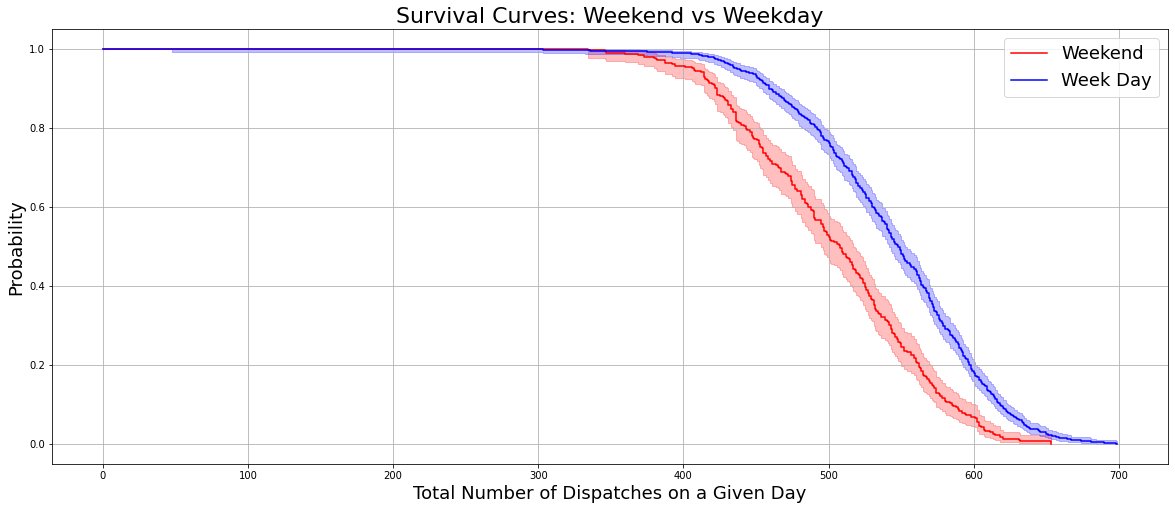

In [22]:
#First analysis, lets see if the number of daily calls changes based on weekday vs weekend

fig,ax = plt.subplots(figsize = (20,8))

condWeekend = (workingDf['dayOfWeek'] >= 5)

kmf.fit(workingDf.loc[condWeekend,['dayOfWeek','date']].groupby('date').count(), label='Weekend')
ax = kmf.plot(color = 'red')

kmf.fit(workingDf.loc[~condWeekend,['dayOfWeek','date']].groupby('date').count(), label='Week Day')
ax = kmf.plot(ax=ax, color = 'blue')

ax.set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
ax.set_ylabel('Probability', fontsize = 18)
ax.set_title('Survival Curves: Weekend vs Weekday', fontsize = 22)
ax.legend(fontsize = 18)
ax.grid(True)

In [23]:
# Nice!  It looks like there are more police dispatches on any given weekday than on the weekends.  If we wanted
# to look at the point estimate, look at how the two curves compare when probability = 0.5.  This would give the
# median number of events per day for weekdays and weekends.  If we wanted to dig deeper we could also perform 
# some type of statistical test (i.e. log-rank), but I'll leave that for another time

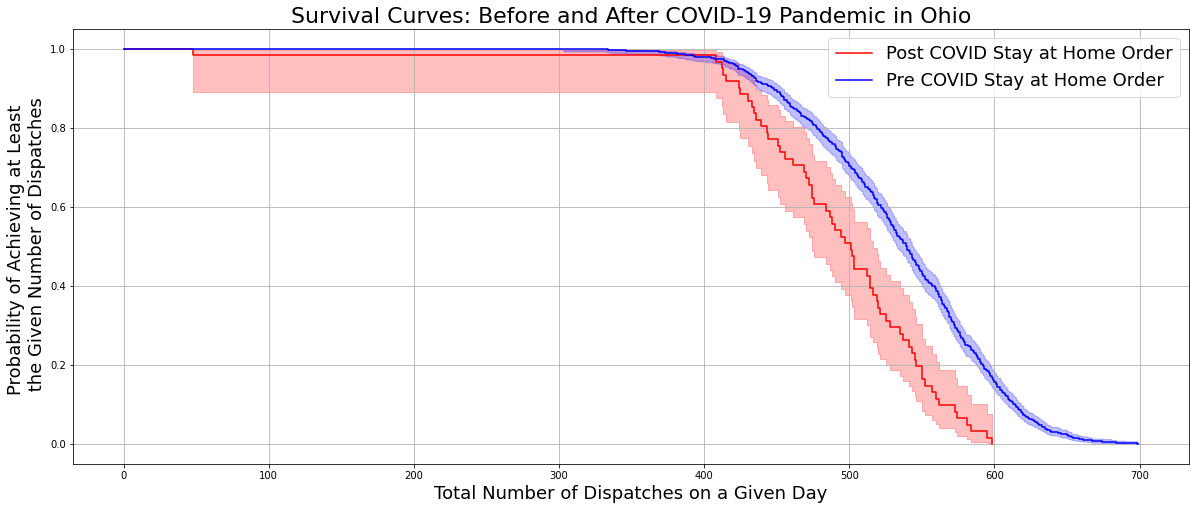

In [24]:
#Now lets look at what a day looked like before COVID-19 and then after the quarantine in Ohio was initiated

fig,ax = plt.subplots(figsize = (20,8))


condpostCovid = (workingDf['dispatch_time_primary_unit'] >= dt(2020,3,22)) #all events after COVID-19.

kmf.fit(workingDf.loc[condpostCovid,['dispatch_time_primary_unit','date']].groupby('date').count(), 
        label='Post COVID Stay at Home Order')
ax = kmf.plot(color = 'red')

kmf.fit(workingDf.loc[~condpostCovid,['dispatch_time_primary_unit','date']].groupby('date').count(), 
        label='Pre COVID Stay at Home Order')
ax = kmf.plot(ax=ax, color = 'blue')

ax.set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
ax.set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
ax.set_title('Survival Curves: Before and After COVID-19 Pandemic in Ohio', fontsize = 22)
ax.legend(fontsize = 18)
ax.grid(True)

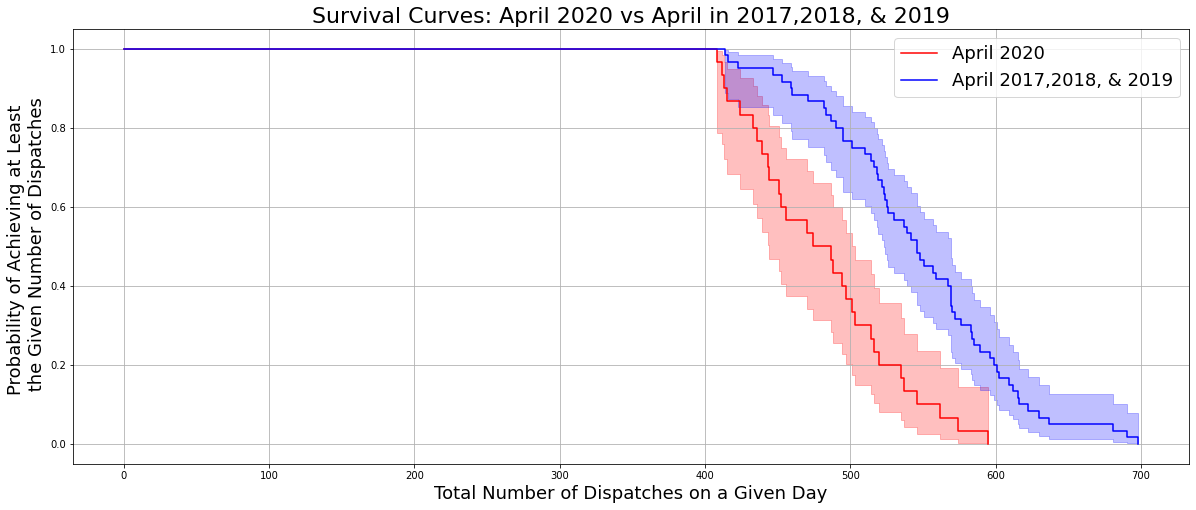

In [25]:
# It looks like there have been less police dispatches following the stay-at-home order by Mike Dewine.  Another
# thing we should look at is how April 2020 compares to the Aprils of last year, especially since we can see from
# the 2D Histogram that there are seasonality patterns with police dispatches

fig,ax = plt.subplots(figsize = (20,8))


condApr2020 = (workingDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2020)
condApr2019 = (workingDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2019)
condApr2018 = (workingDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2018)
condApr2017 = (workingDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2017)




kmf.fit(workingDf.loc[condApr2020,['dispatch_time_primary_unit','date']].groupby('date').count(), 
        label='April 2020')
ax = kmf.plot(color = 'red')

kmf.fit(workingDf.loc[condApr2019|condApr2018|condApr2017,['dispatch_time_primary_unit','date']].groupby('date')\
        .count(), label='April 2017,2018, & 2019')
ax = kmf.plot(ax=ax, color = 'blue')

ax.set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
ax.set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
ax.set_title('Survival Curves: April 2020 vs April in 2017,2018, & 2019', fontsize = 22)
ax.legend(fontsize = 18)
ax.grid(True)

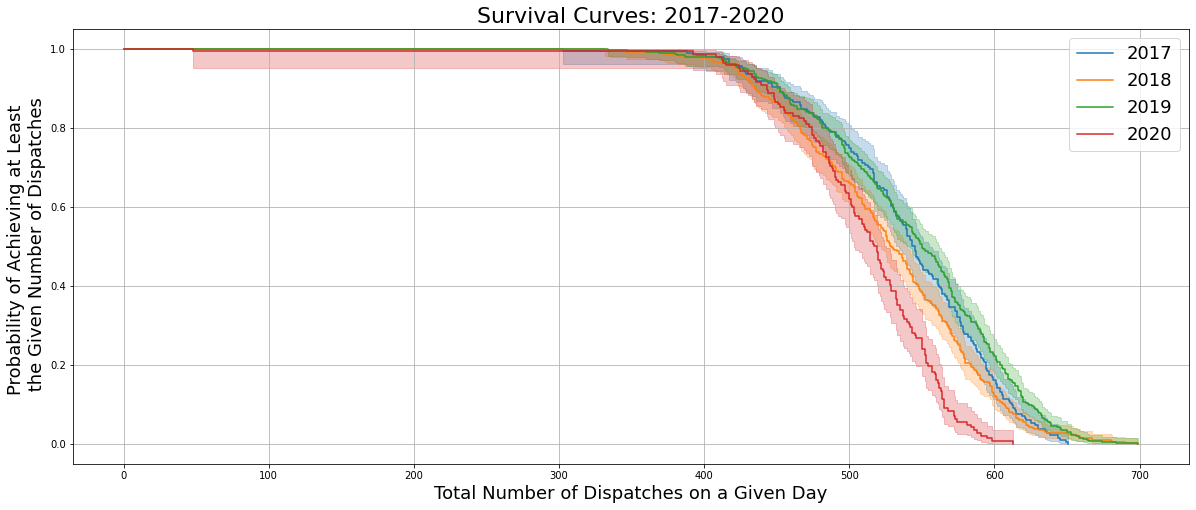

In [26]:
# Lets take a look at the yearly trends to see how Police Dispatches have changed annually.  

fig,ax = plt.subplots(figsize = (20,8))


kmf.fit(workingDf.loc[(workingDf['year'] == 2017),['year','date']].groupby('date').count(), label='2017')
ax = kmf.plot()

kmf.fit(workingDf.loc[(workingDf['year'] == 2018),['year','date']].groupby('date').count(), label='2018')
ax = kmf.plot(ax=ax)

kmf.fit(workingDf.loc[(workingDf['year'] == 2019),['year','date']].groupby('date').count(), label='2019')
ax = kmf.plot(ax=ax)

kmf.fit(workingDf.loc[(workingDf['year'] == 2020),['year','date']].groupby('date').count(), label='2020')
ax = kmf.plot(ax=ax)

ax.set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
ax.set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
ax.set_title('Survival Curves: 2017-2020', fontsize = 22)
ax.legend(fontsize = 18)
ax.grid(True)

In [27]:
# It looks like 2020 has significantly lower dispatches per day than previous years., but remember there are 
# some annual trends we have to account for.  Specifically, we believe there is more activity during the summer
# than during the winter, and 2020 hasn't hit summer yet.  Lets see if we can make those distinctions more apparent

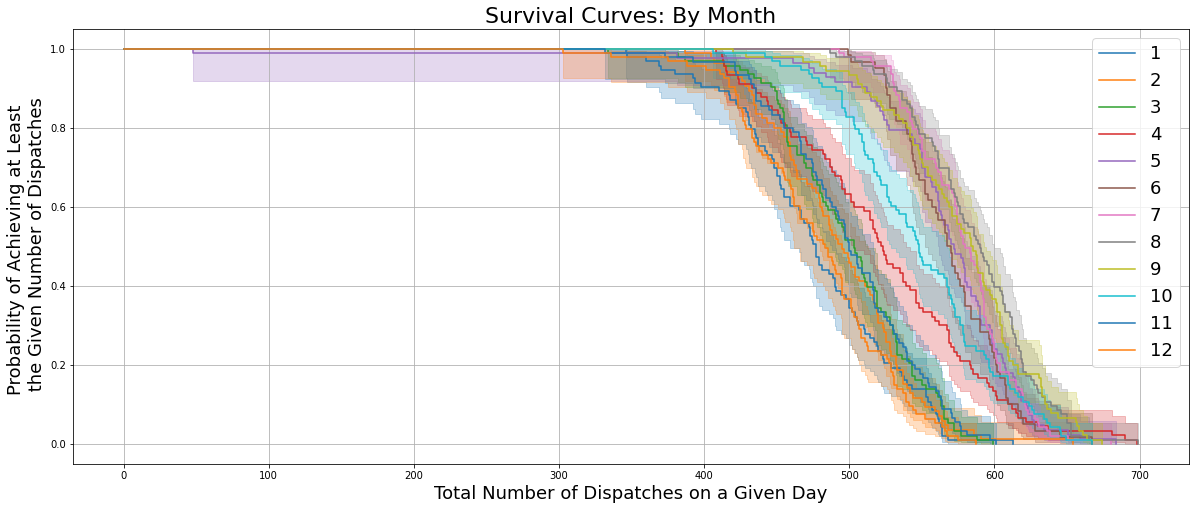

In [28]:
# first lets plot every month individually

fig,ax = plt.subplots(figsize = (20,8))

for i in range(12):
    if i == 0:
        kmf.fit(workingDf.loc[(workingDf['month'] == i+1),['month','date']].groupby('date').count(), label=str(i+1))
        ax = kmf.plot()
    else:
        kmf.fit(workingDf.loc[(workingDf['month'] == i+1),['month','date']].groupby('date').count(), label=str(i+1))
        ax = kmf.plot(ax=ax)

ax.set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
ax.set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
ax.set_title('Survival Curves: By Month', fontsize = 22)
ax.legend(fontsize = 18)
ax.grid(True)

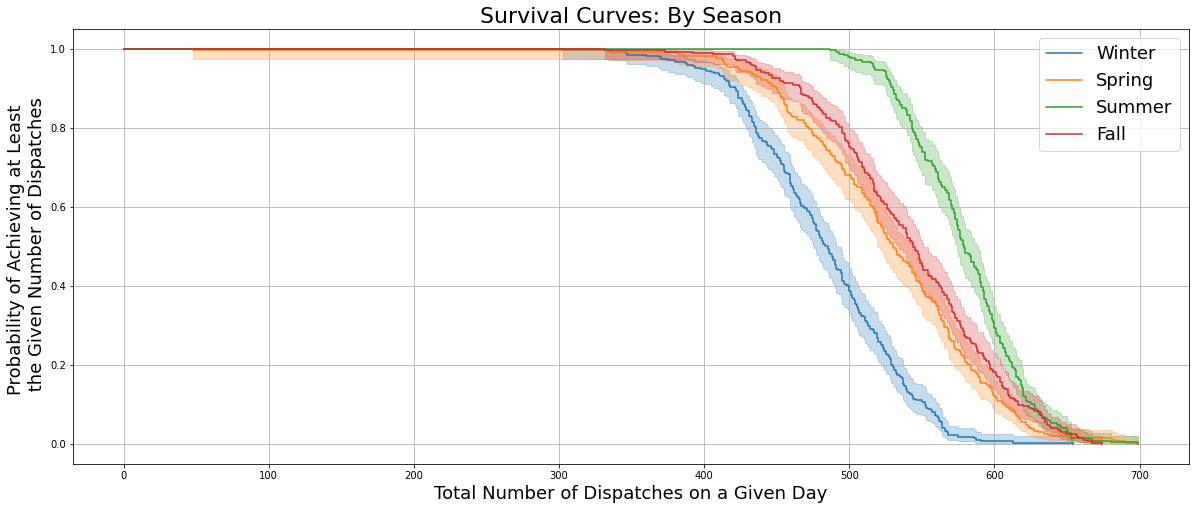

In [29]:
# Kind of hard to see much with a monthly view, although it looks like there are some distinct groupings.  
#  Instead of doing this by month, lets see if we can look at this by season (spring, summer, fall, and winter)
fig,ax = plt.subplots(figsize = (20,8))


kmf.fit(workingDf.loc[(workingDf['month'] == 12)|(workingDf['month'] == 1)|(workingDf['month'] == 2),
                     ['month','date']].groupby('date').count(), label='Winter')
ax = kmf.plot()

kmf.fit(workingDf.loc[(workingDf['month'] == 3)|(workingDf['month'] == 4)|(workingDf['month'] == 5),
                     ['month','date']].groupby('date').count(), label='Spring')
ax = kmf.plot(ax=ax)

kmf.fit(workingDf.loc[(workingDf['month'] == 6)|(workingDf['month'] == 7)|(workingDf['month'] == 8),
                     ['month','date']].groupby('date').count(), label='Summer')
ax = kmf.plot(ax=ax)

kmf.fit(workingDf.loc[(workingDf['month'] == 9)|(workingDf['month'] == 10)|(workingDf['month'] == 11),
                     ['month','date']].groupby('date').count(), label='Fall')
ax = kmf.plot(ax=ax)

ax.set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
ax.set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
ax.set_title('Survival Curves: By Season', fontsize = 22)
ax.legend(fontsize = 18)
ax.grid(True)

In [30]:
# There is a fairly apparent difference in the quantity of 9-1-1 responses in the winter than in the summer!
#  Spring and fall appear to have similar profiles

# Domestic Violence Analysis
### Now that we have a feel for 9-1-1 calls overall, lets see how one particular sort of crime looks in the post COVID-19 world.  We are going to specifically look at domestic violence.  With everyone stuck at home, our hypothesis is that we may observe more domestic violence than we historically have in the past

In [31]:
#First lets try to isolate just the incidences which are possibly related to domestic violence.  

dvCond1 = (results_df['incident_type_desc'] == 'DOMESTIC VIOLENCE')
dvCond2 = (results_df['incident_type_desc'] == 'DOMESTIC VIOLENCE REPORT')
dvCond3 = (results_df['incident_type_desc'] == 'DOMESTIC VIOLENCE W/')
dvCond4 = (results_df['incident_type_desc'] ==  'DOMESTIC VIOLENCE W/ INJURIES')
dvCond5 = (results_df['incident_type_desc'] == 'FAMILY TROUBLE - NON VIOLENT') #debatable: should I include this?
dvCond6 = (results_df['incident_type_desc'] == 'FAMILY TROUBLE') #debatable: should I include this?
dvCond7 = (results_df['incident_type_desc'] == 'DOMESTIC VIOLENCE J/O')
dvCond8 = (results_df['create_time_incident']>=dt(2017,7,1,0,0,0))


dvCondAll = (dvCond1|dvCond2|dvCond3|dvCond4|dvCond5|dvCond6|dvCond7)&dvCond8
#dvCondAll = (dvCond1|dvCond2|dvCond3|dvCond4|dvCond7)&dvCond8


domVioDf = results_df.loc[dvCondAll,:]
domVioDf.describe(include = 'all')

,address_x,agency,arrival_time_primary_unit,beat,closed_time_incident,community_council_neighborhood,cpd_neighborhood,create_time_incident,dispatch_time_primary_unit,disposition_text,district,event_number,incident_type_desc,incident_type_id,latitude_x,longitude_x,priority,priority_color,sna_neighborhood
count,55373,55373,46094,55233,53777,55373,55373,55373,48268,54204,55217,55373,55373,55373,55364.000000,55364.000000,55373,55373,55373
unique,5923,1,46083,24,53756,69,54,55344,48260,168,5,55373,4,4,NaN,NaN,3,3,51
top,4XX W 9TH ST,CPD,2017-07-16 17:39:57,P321,2020-02-16 20:55:25,WESTWOOD,WESTWOOD,2019-02-04 20:29:00,2020-02-01 22:55:34,ADV:ADVISED,3,CPD180301000104,FAMILY TROUBLE - NON VIOLENT,FAMTRB,NaN,NaN,25,PURPLE,WESTWOOD
freq,315,55373,2,7583,2,6577,6421,2,2,21627,20699,1,46731,46731,NaN,NaN,46731,46731,6454
first,NaN,NaN,2017-07-01 00:16:31,NaN,2017-07-01 00:37:50,NaN,NaN,2017-07-01 00:10:21,2017-07-01 00:11:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-05-21 01:58:24,NaN,2020-05-21 02:03:15,NaN,NaN,2020-05-21 01:51:02,2020-05-21 01:51:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.145035,-84.527841,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031515,0.055133,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.969117,-84.802137,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.118720,-84.570180,NaN,NaN,NaN


In [32]:
# Lets create a separate dvPlotDf dataframe that lets us know how many of these types of 9-1-1 calls occur per day

dvPlotDf = results_df.loc[dvCondAll,['create_time_incident']]
dvPlotDf['date'] = results_df.loc[dvCondAll,['create_time_incident']]['create_time_incident'].dt.date
dvPlotDf = dvPlotDf.groupby('date').count()

dvPlotDf.head()

,create_time_incident
date,
2017-07-01,61
2017-07-02,46
2017-07-03,58
2017-07-04,74
2017-07-05,83


In [33]:
dvPlotDf.sum()

create_time_incident    55373
dtype: int64

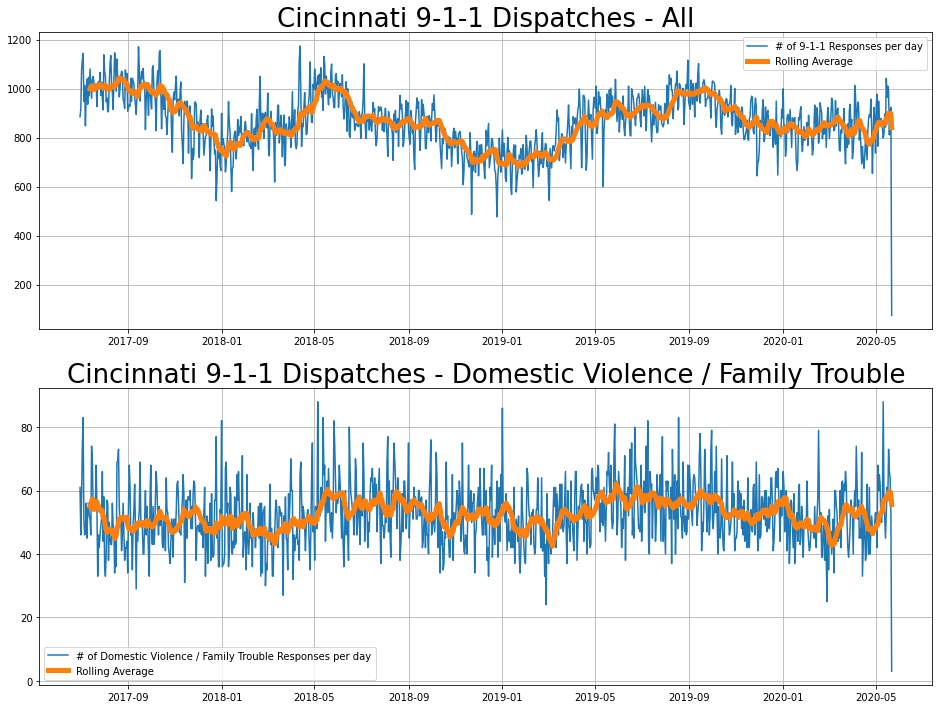

In [34]:
# Looking at just the count of incidents per day, lets see if we can see any visible patterns in the data
# Future work could be done to identify temporal patterns and predict future activity (i.e. ARIMA, Prophet, etc)
# But for now lets just looking at the data and the rolling averages

#fig, ax = plt.figure(figsize = (16,12))
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (16,12))


axs[0].plot(plotDf.index,plotDf['create_time_incident'], label = '# of 9-1-1 Responses per day')

rollingDf = plotDf.rolling(14).mean() #2-week rolling average

axs[0].plot(rollingDf.index,rollingDf['create_time_incident'], lw = 5, label = 'Rolling Average') 

axs[0].legend(loc='best')
axs[0].grid(True)
axs[0].set_title('Cincinnati 9-1-1 Dispatches - All', size = 26)

# Now plot just the Domestic Violence incidences
axs[1].plot(dvPlotDf.index,dvPlotDf['create_time_incident'], 
            label = '# of Domestic Violence / Family Trouble Responses per day')

rollingDf = dvPlotDf.rolling(14).mean() #2-week rolling average

axs[1].plot(rollingDf.index,rollingDf['create_time_incident'], lw = 5, label = 'Rolling Average') 

axs[1].legend(loc='best')
axs[1].grid(True)
axs[1].set_title('Cincinnati 9-1-1 Dispatches - Domestic Violence / Family Trouble', size = 26)

#plt.savefig('DomesticVioFamDisturb_19MAY2020.png')
plt.show()

In [35]:
# Now lets start looking at some other temporal patterns from the data.  Create some new columns that look at 
# some of the temporal characteristics (day, month, hour, year, date, dayOfWeek, etc)

domVioDf['day'] = domVioDf['dispatch_time_primary_unit'].dt.day
domVioDf['month'] = domVioDf['dispatch_time_primary_unit'].dt.month
domVioDf['hour'] = domVioDf['dispatch_time_primary_unit'].dt.hour
domVioDf['year'] = domVioDf['dispatch_time_primary_unit'].dt.year
domVioDf['date'] = domVioDf['dispatch_time_primary_unit'].dt.date
domVioDf['dayOfWeek'] = domVioDf['dispatch_time_primary_unit'].dt.dayofweek


domVioDf.tail()

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,address_x,agency,arrival_time_primary_unit,beat,closed_time_incident,community_council_neighborhood,cpd_neighborhood,create_time_incident,dispatch_time_primary_unit,disposition_text,...,longitude_x,priority,priority_color,sna_neighborhood,day,month,hour,year,date,dayOfWeek
3130871,30XX WALTER AV,CPD,2020-05-20 12:49:53,P421,2020-05-20 13:45:10,WALNUT HILLS,WALNUT HILLS,2020-05-20 12:06:03,2020-05-20 12:44:14,AST: ASSIST,...,-84.486763,25,PURPLE,WALNUT HILLS,20.0,5.0,12.0,2020.0,2020-05-20,2.0
3130887,2XX GOODMAN ST,CPD,2020-05-20 21:42:25,P411,2020-05-20 22:11:45,CORRYVILLE,CORRYVILLE,2020-05-20 21:38:18,2020-05-20 21:38:18,AST: ASSIST,...,-84.503722,4,YELLOW,CORRYVILLE,20.0,5.0,21.0,2020.0,2020-05-20,2.0
3130935,23XX FERGUSON RD,CPD,2020-05-20 23:07:23,P331,2020-05-20 23:15:18,WESTWOOD,WESTWOOD,2020-05-20 23:07:23,2020-05-20 23:07:23,SOW: SENT ON WAY,...,-84.600872,25,PURPLE,WESTWOOD,20.0,5.0,23.0,2020.0,2020-05-20,2.0
3130963,2XX FOSDICK ST,CPD,NaT,P411,2020-05-20 16:17:20,CORRYVILLE,CORRYVILLE,2020-05-20 15:59:42,NaT,CAN:CANCEL,...,-84.504591,25,PURPLE,CORRYVILLE,NaN,NaN,NaN,NaN,NaT,NaN
3130970,W LIBERTY ST / CENTRAL PKWY,CPD,2020-05-20 16:12:29,P131,2020-05-20 17:45:17,WEST END,WEST END,2020-05-20 16:09:07,2020-05-20 16:09:26,AST: ASSIST,...,-84.521000,25,PURPLE,WEST END,20.0,5.0,16.0,2020.0,2020-05-20,2.0


In [36]:

# The first thing we will do is create a 2-dimensional histogram to visualize what time of day crimes occur and 
# when, and how that changes over time.  To start with, lets create a histogram that includes just the dispatch 
# time (date & time) and the hour (integer)
hour2DHistDf = domVioDf.loc[:,['dispatch_time_primary_unit','hour']].dropna()\
.sort_values(['dispatch_time_primary_unit','hour'])


1056


Text(0.5, 1.0, '9-1-1 Calls for Domestic Violence / Family Disturbance: 2D Histogram')

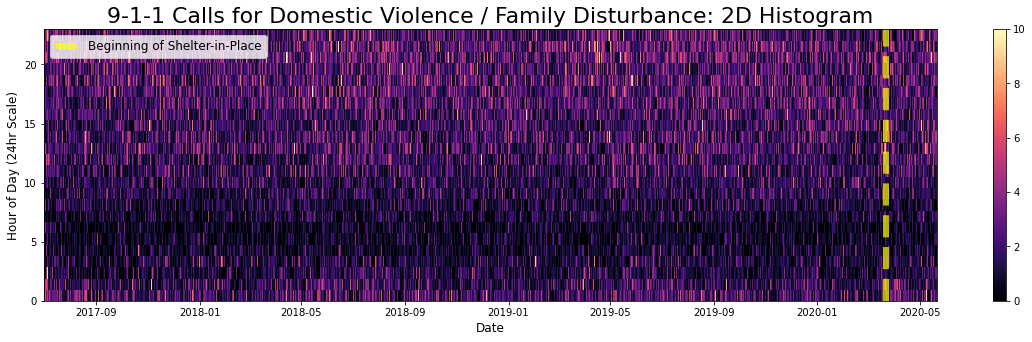

In [37]:
#Plot the 2-dimensional histogram, while annotating when the quarantine began in Ohio

fig,ax = plt.subplots(figsize = (20,5))

n_days = len(np.unique(hour2DHistDf['dispatch_time_primary_unit'].dt.date.values))
print(n_days)

H, xedges, yedges = np.histogram2d(hour2DHistDf['dispatch_time_primary_unit'].astype(int), hour2DHistDf['hour'], bins=(n_days, 24))

xedges_datetime= pd.to_datetime(pd.Series(xedges))

graph = ax.pcolor(xedges_datetime, yedges, H.T, cmap = 'magma')

#plot the vertical line at the beginning of the quarantine
ax.axvline(dt(2020,3,22), lw = 6, color = 'yellow',ls = '--', alpha = .7, label = 'Beginning of Shelter-in-Place')

ax.legend(fontsize = 12)

from matplotlib import cm

fig.colorbar(graph)

ax.set_xlabel('Date', fontsize = 12)
ax.set_ylabel('Hour of Day (24hr Scale)', fontsize = 12)
ax.set_title('9-1-1 Calls for Domestic Violence / Family Disturbance: 2D Histogram', fontsize = 22)




In [38]:
#Patterns are a little less obvious, although there still remains a lull in activity around 5am

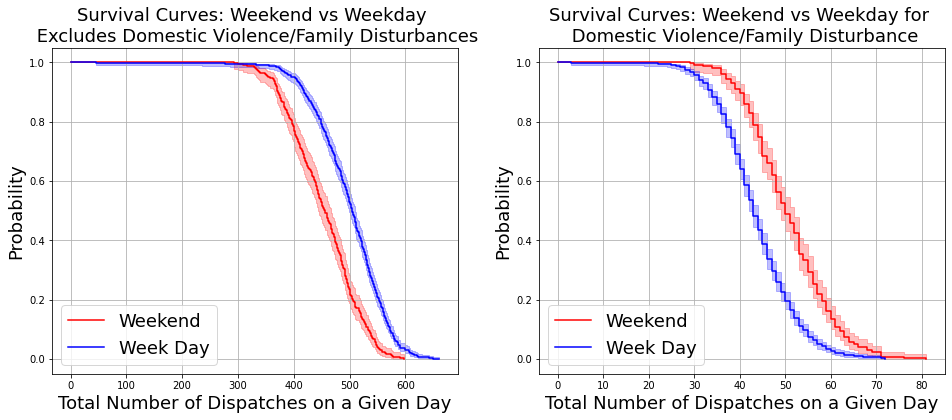

In [39]:
#First analysis, lets see if the number of daily calls changes based on weekday vs weekend, and compare 
# domestic violence/family disturbances with each other

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))


condWeekend = (workingDf['dayOfWeek'] >= 5)

kmf.fit(workingDf.loc[condWeekend&~dvCondAll,['dayOfWeek','date']].groupby('date').count(), label='Weekend')
kmf.plot(ax = axs[0], color = 'red')

kmf.fit(workingDf.loc[~condWeekend&~dvCondAll,['dayOfWeek','date']].groupby('date').count(), label='Week Day')
kmf.plot(ax=axs[0], color = 'blue')

axs[0].set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
axs[0].set_ylabel('Probability', fontsize = 18)
axs[0].set_title('Survival Curves: Weekend vs Weekday \n Excludes Domestic Violence/Family Disturbances', 
                 fontsize = 18)
axs[0].legend(loc = 'lower left', fontsize = 18)
axs[0].grid(True)

#Now do the same for the domestic violence plot
kmf.fit(domVioDf.loc[condWeekend,['dayOfWeek','date']].groupby('date').count(), label='Weekend')
kmf.plot(ax = axs[1], color = 'red')

kmf.fit(domVioDf.loc[~condWeekend,['dayOfWeek','date']].groupby('date').count(), label='Week Day')
kmf.plot(ax=axs[1], color = 'blue')

axs[1].set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
axs[1].set_ylabel('Probability', fontsize = 18)
axs[1].set_title('Survival Curves: Weekend vs Weekday for \n Domestic Violence/Family Disturbance', 
                 fontsize = 18)
axs[1].legend(loc = 'lower left', fontsize = 18)
axs[1].grid(True)

In [40]:
# This is interesting:  Weekends tend to have more police dispatches for domestic violence/family disturbances
# than weekdays.  However, this is the exact opposite trend for all other forms of police dispatches!

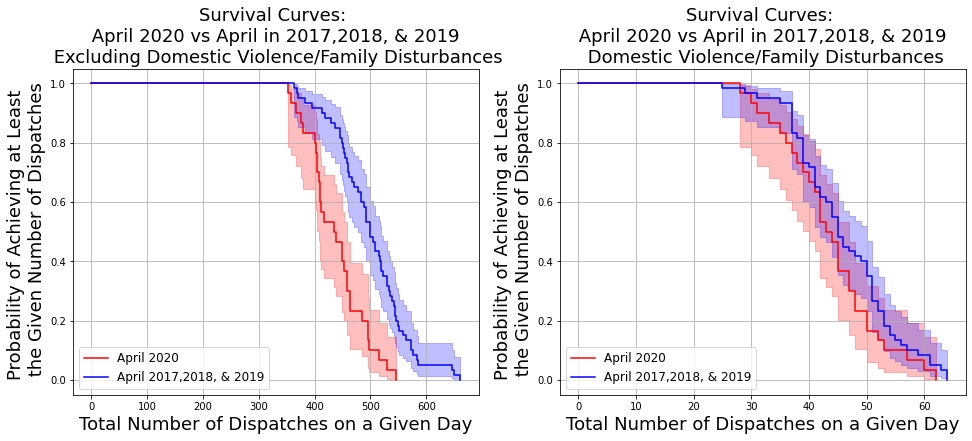

In [41]:
#Now lets compare April months for all crimes excluding domVio/family disturbances, and then just inclusive for 
# domestic violence/family disturbances

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))


condApr2020 = (workingDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2020)
condApr2019 = (workingDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2019)
condApr2018 = (workingDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2018)
condApr2017 = (workingDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2017)


kmf.fit(workingDf.loc[condApr2020&~dvCondAll,['dispatch_time_primary_unit','date']].groupby('date').count(), 
        label='April 2020')
axs[0] = kmf.plot(ax = axs[0], color = 'red')

kmf.fit(workingDf.loc[(condApr2019|condApr2018|condApr2017)&~dvCondAll,['dispatch_time_primary_unit','date']].groupby('date')\
        .count(), label='April 2017,2018, & 2019')
ax = kmf.plot(ax=axs[0], color = 'blue')

axs[0].set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
axs[0].set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
axs[0].set_title('Survival Curves: \n April 2020 vs April in 2017,2018, & 2019 \n Excluding Domestic Violence/Family Disturbances', fontsize = 18)
axs[0].legend(fontsize = 12)
axs[0].grid(True)

#Now lets do the same for domestc violence/family disturbances
condApr2020 = (domVioDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2020)
condApr2019 = (domVioDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2019)
condApr2018 = (domVioDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2018)
condApr2017 = (domVioDf['dispatch_time_primary_unit'].dt.month == 4)\
&(workingDf['dispatch_time_primary_unit'].dt.year == 2017)


kmf.fit(domVioDf.loc[condApr2020,['dispatch_time_primary_unit','date']].groupby('date').count(), 
        label='April 2020')
kmf.plot(ax = axs[1], color = 'red')

kmf.fit(domVioDf.loc[(condApr2019|condApr2018|condApr2017),['dispatch_time_primary_unit','date']].groupby('date')\
        .count(), label='April 2017,2018, & 2019')
kmf.plot(ax=axs[1], color = 'blue')

axs[1].set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
axs[1].set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
axs[1].set_title('Survival Curves: \n April 2020 vs April in 2017,2018, & 2019 \n Domestic Violence/Family Disturbances', fontsize = 18)
axs[1].legend(fontsize = 12)
axs[1].grid(True)

In [42]:
#That is ALSO interesting.... while it seems most other crimes have gone down after COVID-19, there appears to 
# be no significant change for domestic violence and family disturbances.  

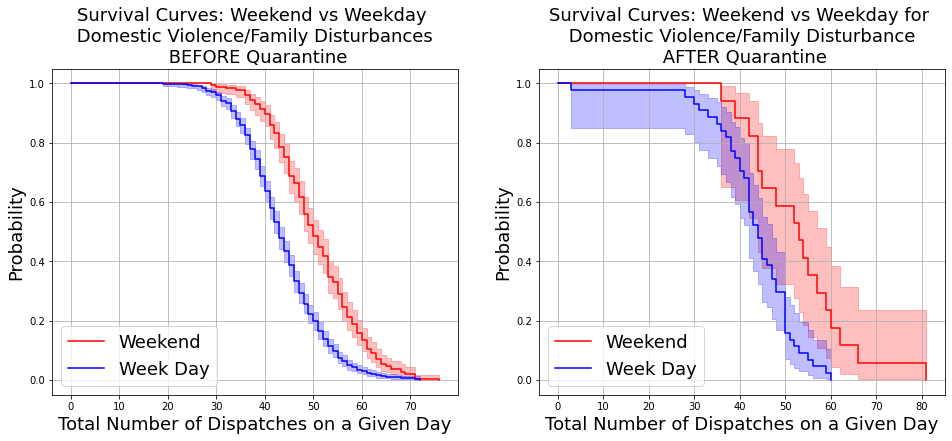

In [43]:
#Here's a hypothesis:  We know that there are more domestic violence / family disturbances over the weekend
# than during the weekday.  Perhaps now that everyone is in quarantine, there is no longer a difference?  
#  Let's see



fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))


condWeekend = (domVioDf['dayOfWeek'] >= 5)
condPreCovid = (domVioDf['dispatch_time_primary_unit'] < dt(2020,3,22))

#First plot: domestic violence/fam disturbances before COVID, broken out by weekday/weekend
kmf.fit(domVioDf.loc[condWeekend&condPreCovid,['dayOfWeek','date']].groupby('date').count(), label='Weekend')
kmf.plot(ax = axs[0], color = 'red')

kmf.fit(domVioDf.loc[~condWeekend&condPreCovid,['dayOfWeek','date']].groupby('date').count(), label='Week Day')
kmf.plot(ax=axs[0], color = 'blue')

axs[0].set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
axs[0].set_ylabel('Probability', fontsize = 18)
axs[0].set_title('Survival Curves: Weekend vs Weekday \n Domestic Violence/Family Disturbances \n BEFORE Quarantine', 
                 fontsize = 18)
axs[0].legend(loc = 'lower left', fontsize = 18)
axs[0].grid(True)

#Now do the same for the domestic violence plot
kmf.fit(domVioDf.loc[condWeekend&~condPreCovid,['dayOfWeek','date']].groupby('date').count(), label='Weekend')
kmf.plot(ax = axs[1], color = 'red')

kmf.fit(domVioDf.loc[~condWeekend&~condPreCovid,['dayOfWeek','date']].groupby('date').count(), label='Week Day')
kmf.plot(ax=axs[1], color = 'blue')

axs[1].set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
axs[1].set_ylabel('Probability', fontsize = 18)
axs[1].set_title('Survival Curves: Weekend vs Weekday for \n Domestic Violence/Family Disturbance \n AFTER Quarantine', 
                 fontsize = 18)
axs[1].legend(loc = 'lower left', fontsize = 18)
axs[1].grid(True)

In [44]:
#I wouldnt count this as clear proof of what we are looking for, which is informative in of itself.  A more 
# thorough statistical test is needed, but I do not think we can say that the weekend/weekday difference post
# COVID 19 is weaker because people are staying at home

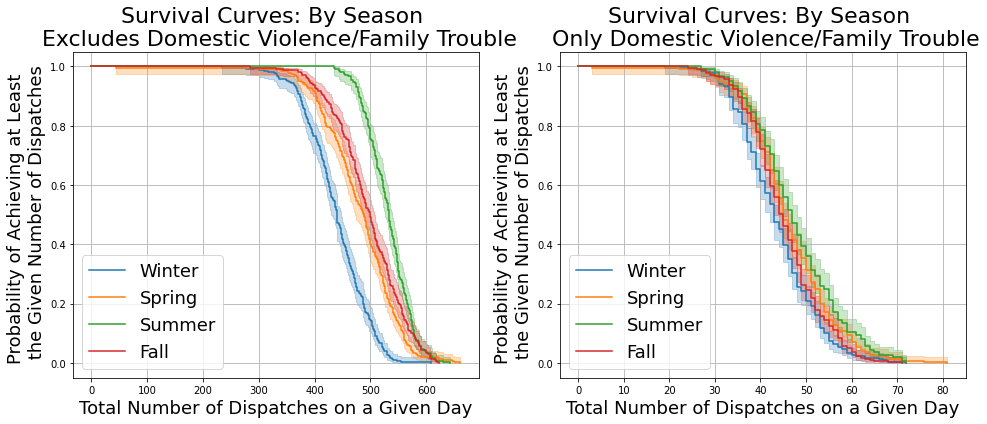

In [45]:
# Last test:  Lets see what the seasonality differences are for family disturbances / domestic violence

# Kind of hard to see much with a monthly view, although it looks like there are some distinct groupings.  
#  Instead of doing this by month, lets see if we can look at this by season (spring, summer, fall, and winter)
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))

kmf.fit(workingDf.loc[((workingDf['month'] == 12)|(workingDf['month'] == 1)|(workingDf['month'] == 2))&~dvCondAll,
                     ['month','date']].groupby('date').count(), label='Winter')
kmf.plot(ax = axs[0])

kmf.fit(workingDf.loc[((workingDf['month'] == 3)|(workingDf['month'] == 4)|(workingDf['month'] == 5))&~dvCondAll,
                     ['month','date']].groupby('date').count(), label='Spring')
kmf.plot(ax=axs[0])

kmf.fit(workingDf.loc[((workingDf['month'] == 6)|(workingDf['month'] == 7)|(workingDf['month'] == 8))&~dvCondAll,
                     ['month','date']].groupby('date').count(), label='Summer')
ax = kmf.plot(ax=axs[0])

kmf.fit(workingDf.loc[((workingDf['month'] == 9)|(workingDf['month'] == 10)|(workingDf['month'] == 11))&~dvCondAll,
                     ['month','date']].groupby('date').count(), label='Fall')
ax = kmf.plot(ax=axs[0])

axs[0].set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
axs[0].set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
axs[0].set_title('Survival Curves: By Season \n Excludes Domestic Violence/Family Trouble', fontsize = 22)
axs[0].legend(loc = 'lower left', fontsize = 18)
axs[0].grid(True)

#Now plot for the domestic violence / family disturbances
kmf.fit(domVioDf.loc[((domVioDf['month'] == 12)|(domVioDf['month'] == 1)|(domVioDf['month'] == 2)),
                     ['month','date']].groupby('date').count(), label='Winter')
kmf.plot(ax = axs[1])

kmf.fit(domVioDf.loc[((domVioDf['month'] == 3)|(domVioDf['month'] == 4)|(domVioDf['month'] == 5)),
                     ['month','date']].groupby('date').count(), label='Spring')
kmf.plot(ax=axs[1])

kmf.fit(domVioDf.loc[((domVioDf['month'] == 6)|(domVioDf['month'] == 7)|(domVioDf['month'] == 8)),
                     ['month','date']].groupby('date').count(), label='Summer')
ax = kmf.plot(ax=axs[1])

kmf.fit(domVioDf.loc[((domVioDf['month'] == 9)|(domVioDf['month'] == 10)|(domVioDf['month'] == 11)),
                     ['month','date']].groupby('date').count(), label='Fall')
ax = kmf.plot(ax=axs[1])

axs[1].set_xlabel('Total Number of Dispatches on a Given Day', fontsize = 18)
axs[1].set_ylabel('Probability of Achieving at Least \n the Given Number of Dispatches', fontsize = 18)
axs[1].set_title('Survival Curves: By Season \n Only Domestic Violence/Family Trouble', fontsize = 22)
axs[1].legend(loc = 'lower left',fontsize = 18)
axs[1].grid(True)

Interesting.... it looks like the seasonality for all police dispatches is much more prevalent than the seasonality for domestic violence/family disturbances.  There's still some seasonality there, but not a whole lot (would know more if we did a statistical test). What we don't know is if there are other types of incidences that are driving the overall trends in seasonality and weekend/weekday, which would be more appropriately answered using modeling.  

The next phase of this analysis will involve modeling all of these variables to better understand confounding/interacting relationships and perhaps end with a model that can give us approximate number of police dispatches expected per day as a function of types of incident, weekday/weekend, season, and pre/post covid.  If we stick to survival analysis, this can be done using the Cox Proportional Hazard model within lifelines, as well as some more advanced modeling methods (XGBoost has Cox Proportional Hazard modeling as well as Accelerated Time to Failure (ATF)).  

But for now I am comfortable making the following assumptions:
- Weekdays tend to have more crime than weekends, except for domestic violence/household disturbances, which are the exact opposite
- Overall crime has decreased per day during the time of COVID-19 quarantine, although for domestic violence/household disturbances this trend is likely not statistically relevant.  
- There are strong seasonality trends in the number of police dispatches per day, with winter having less 9-1-1 dispatches than summer (fall and spring are a toss up in between the other two seasons).  This is not true however for domestic violence/household disturbances, where the seasonal trends are much less pronounced